In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Model import KMeans
from matplotlib.patches import Circle
import pandas as pd
import math
from Cluster_Metrics import adjusted_rand_score

The goal of k-means is to partition a dataset into k clusters in such a way that the sum of the squared distances between the data points and their assigned cluster centroids is minimized.

if we sort the data based on labels, then the prediction labels are same as each other?

In [3]:
def plot_kmeans_clusters(X, centroids, labels, nstd=2, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    for i in range(centroids.shape[0]):
        points_in_cluster = X[labels == i]
        if points_in_cluster.shape[0] > 0:
            avg_distance = np.mean(np.sqrt(np.sum((points_in_cluster - centroids[i])**2, axis=1)))
            circle = Circle(centroids[i], avg_distance * nstd, color='red', fill=False, linestyle='--', linewidth=2)
            ax.add_patch(circle)

    return ax


In [4]:
def normalization(data):
    demean = data - data.mean()
    unit_variance = demean / data.std()
    return unit_variance

# Q1

In [5]:
def load_data(dataset_path):
    data = pd.read_csv("Datasets/"+ dataset_path)
    y_true = data['class']
    data = data.drop('class', axis=1)
    return data, y_true

In [6]:
def destandardize(data, mean, std):
    return data * std + mean

In [7]:
datasets_path = ['banana.csv','blobs.csv','dartboard2.csv','elliptical.csv','twenty.csv']
datasets = []
metrics = []
for dataset_path in datasets_path:
    data, labels = load_data(dataset_path)
    metrics.append((data.mean(),data.std()))
    data = normalization(data)
    datasets.append((data,labels))

# Q2

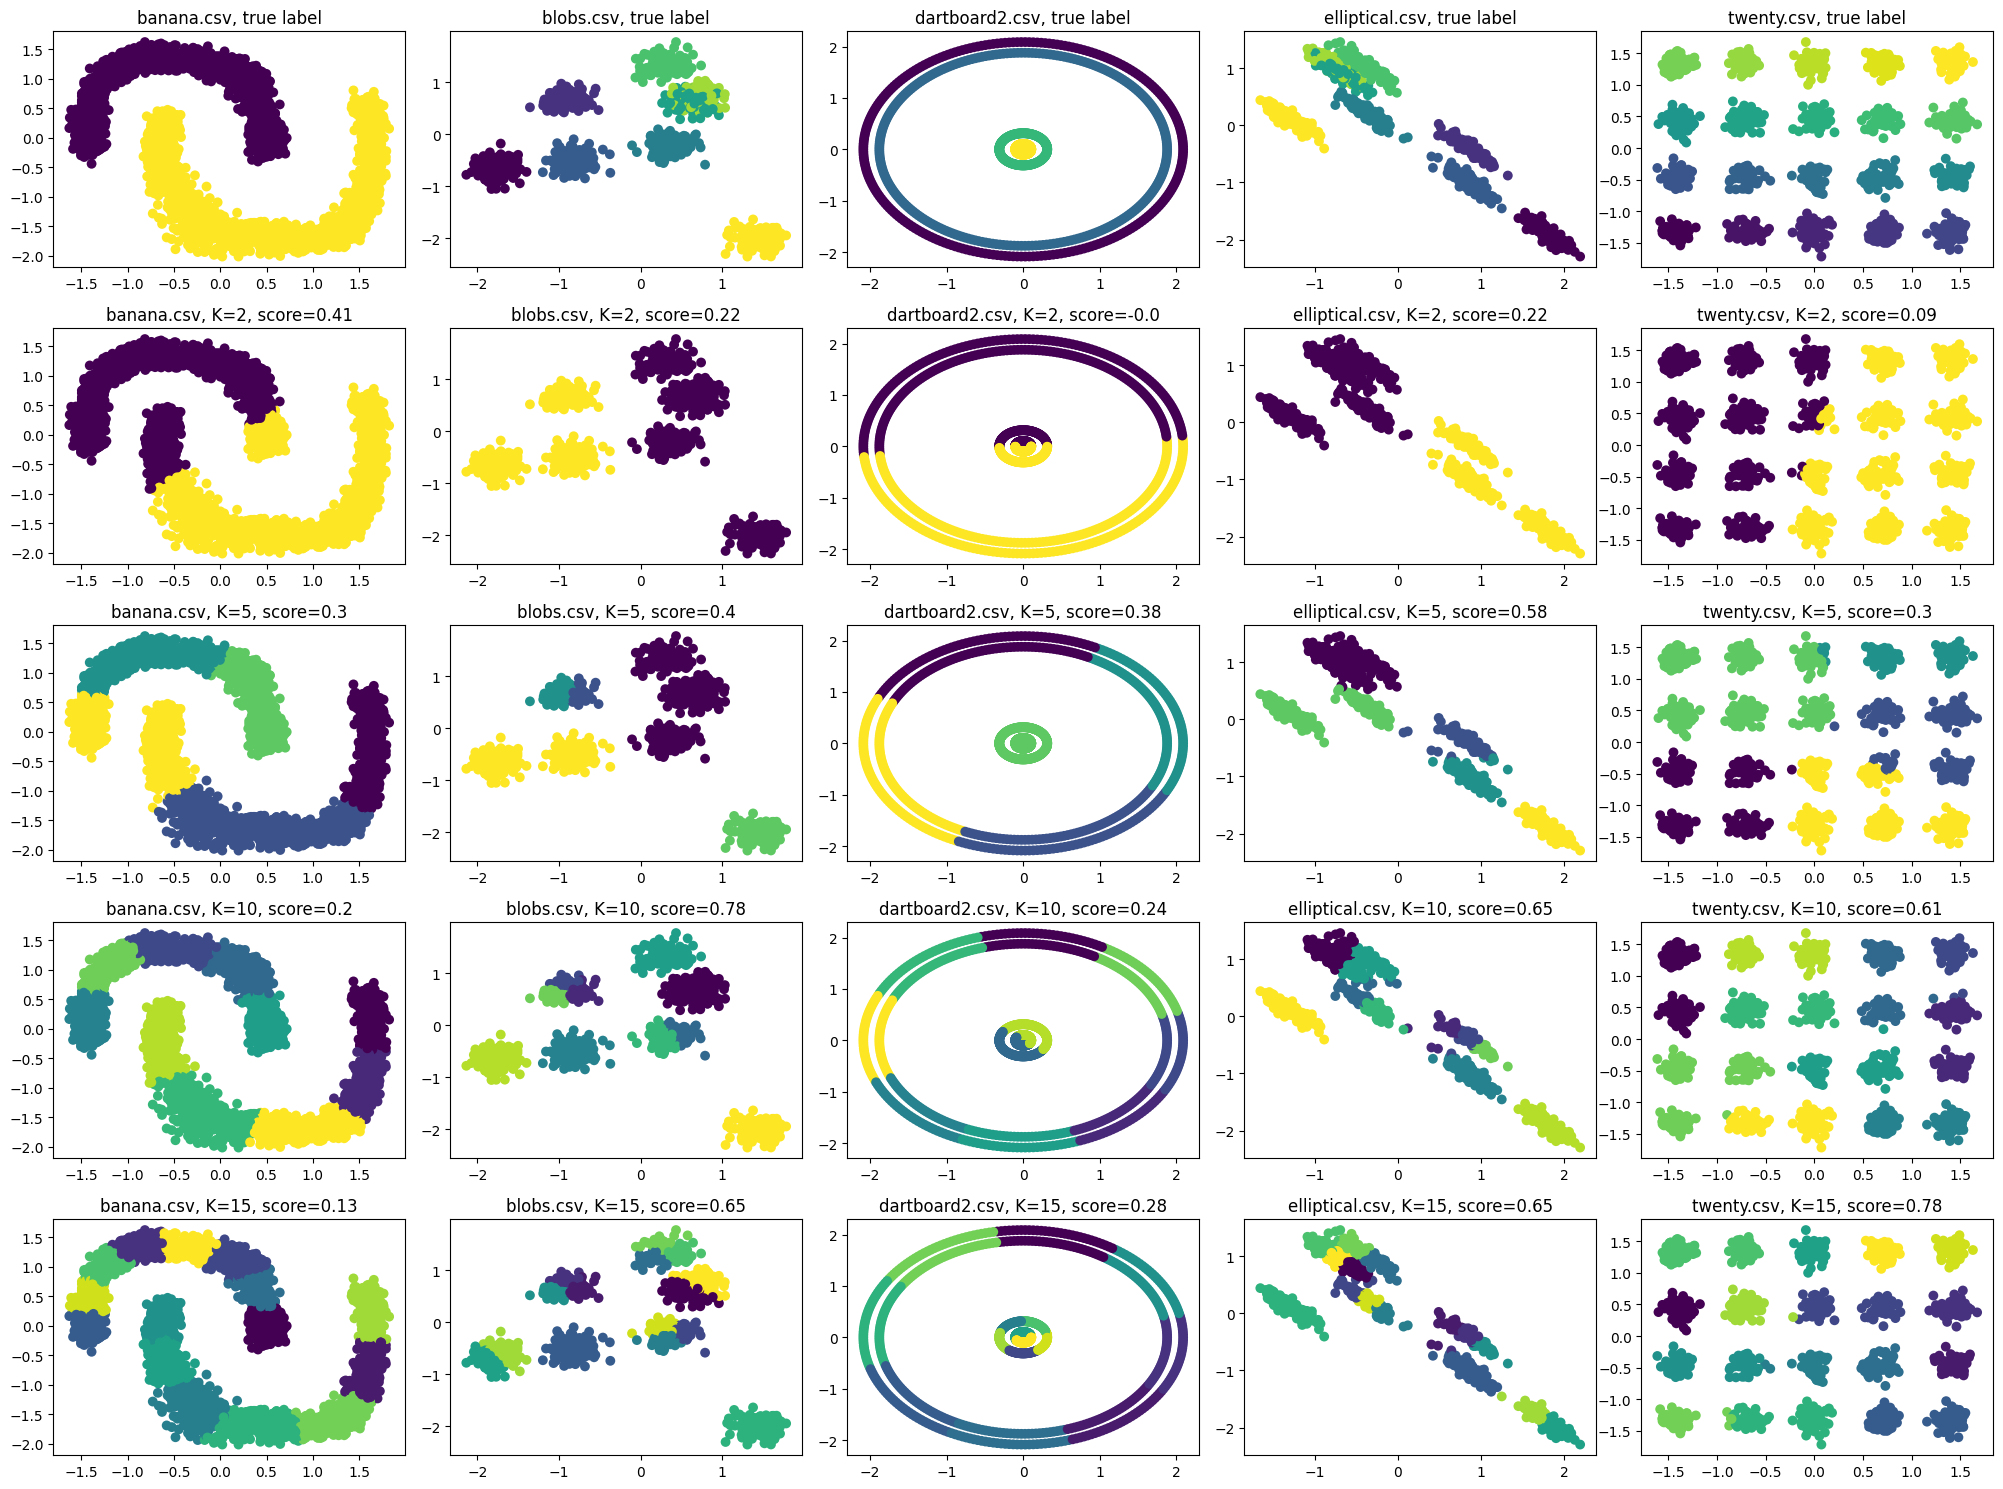

In [8]:
k_values = [2,5,10,15]

fig, axs = plt.subplots(len(k_values)+1, len(datasets), figsize=(20, 15))
for j, (dataset, labels) in enumerate(datasets):
    axs[0, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', linewidth=0)
    axs[0, j].set_title(f'{datasets_path[j]}, true label')
    
for i, k in enumerate(k_values):
    for j, (dataset, y_true) in enumerate(datasets):
        kmeans = KMeans(k, random_state=42)
        y_pred = kmeans.fit_predict(dataset.values)
        axs[i+1, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=y_pred, cmap='viridis', s=50, edgecolors='k', linewidth=0)
        ari = adjusted_rand_score(np.array(y_true), np.array(y_pred))
#         plot_kmeans_clusters(dataset, kmeans.centroids, y_pred, ax=axs[i, j])
        axs[i+1, j].set_title(f'{datasets_path[j]}, K={k}, score={np.round(ari,2)}')

plt.tight_layout()
plt.show()

# Q3

1. **Well-Separated Clusters:** K-means is most effective when clusters in the data are well-separated and have a relatively simple geometric shape, such as spherical clusters. The algorithm assumes that clusters are roughly spherical and equally sized, and it may struggle with non-convex or elongated clusters.

2. **Similar Cluster Sizes:** K-means works better when the clusters in the dataset have similar sizes. If clusters vary significantly in size, the algorithm may assign more points to larger clusters, impacting the quality of the clustering.

3. **Numeric Data:** K-means is well-suited for datasets with numeric features. It calculates means and distances, which are natural operations in a numeric space. If the data includes categorical variables, additional preprocessing may be needed.

4. **Low-Dimensional Data:** K-means can handle data with a moderate number of dimensions, but its performance may degrade in high-dimensional spaces (the curse of dimensionality). In such cases, techniques like dimensionality reduction may be useful.

5. **Linear Separability:** K-means performs better when the underlying structure of the data is approximately linear.


7. **Robust to Outliers:** K-means can be robust to outliers to some extent, as it is based on minimizing the sum of squared distances. However, in the presence of outliers, the centroid of a cluster may be pulled toward them.



K-means may not perform optimally on datasets with non-spherical or non-convex clusters.

1. **Banana Dataset:**
   - K-means is likely to struggle with the Banana dataset because the clusters have a non-convex, banana-like shape.
   - The visualization may show clusters that are not aligned with the true structure of the data.

2. **Dartboard Dataset:**
   - K-means might face challenges with the Dartboard dataset as well, given the circular regions with varying densities.
   - The algorithm may form clusters that are not circular, and it may not handle well clusters of different shapes and densities.

3. **Blobs Elliptical Twenty Dataset:**
   - K-means is expected to perform reasonably well on the Blobs Elliptical Twenty dataset since the clusters are isotropic Gaussian blobs.
   - However, if the clusters are strongly elongated or have non-spherical shapes, K-means may not capture them perfectly, like Elliptical dataset.

It's important to note that K-means makes certain assumptions about the data, such as isotropic clusters of roughly equal size. When these assumptions are violated, the algorithm's performance may degrade.

# Q5

WCSS = Within-Cluster Sum of Squares:

$$ WCSS = \sum_{i=1}^{k} \sum_{j=1}^{n_i} \| x_{ij} - c_i \|^2 $$
WCSS is primarily used for selecting the optimal number of clusters (k) in algorithms like k-means, where the goal is to minimize the sum of squared distances between data points and their assigned cluster centroids.

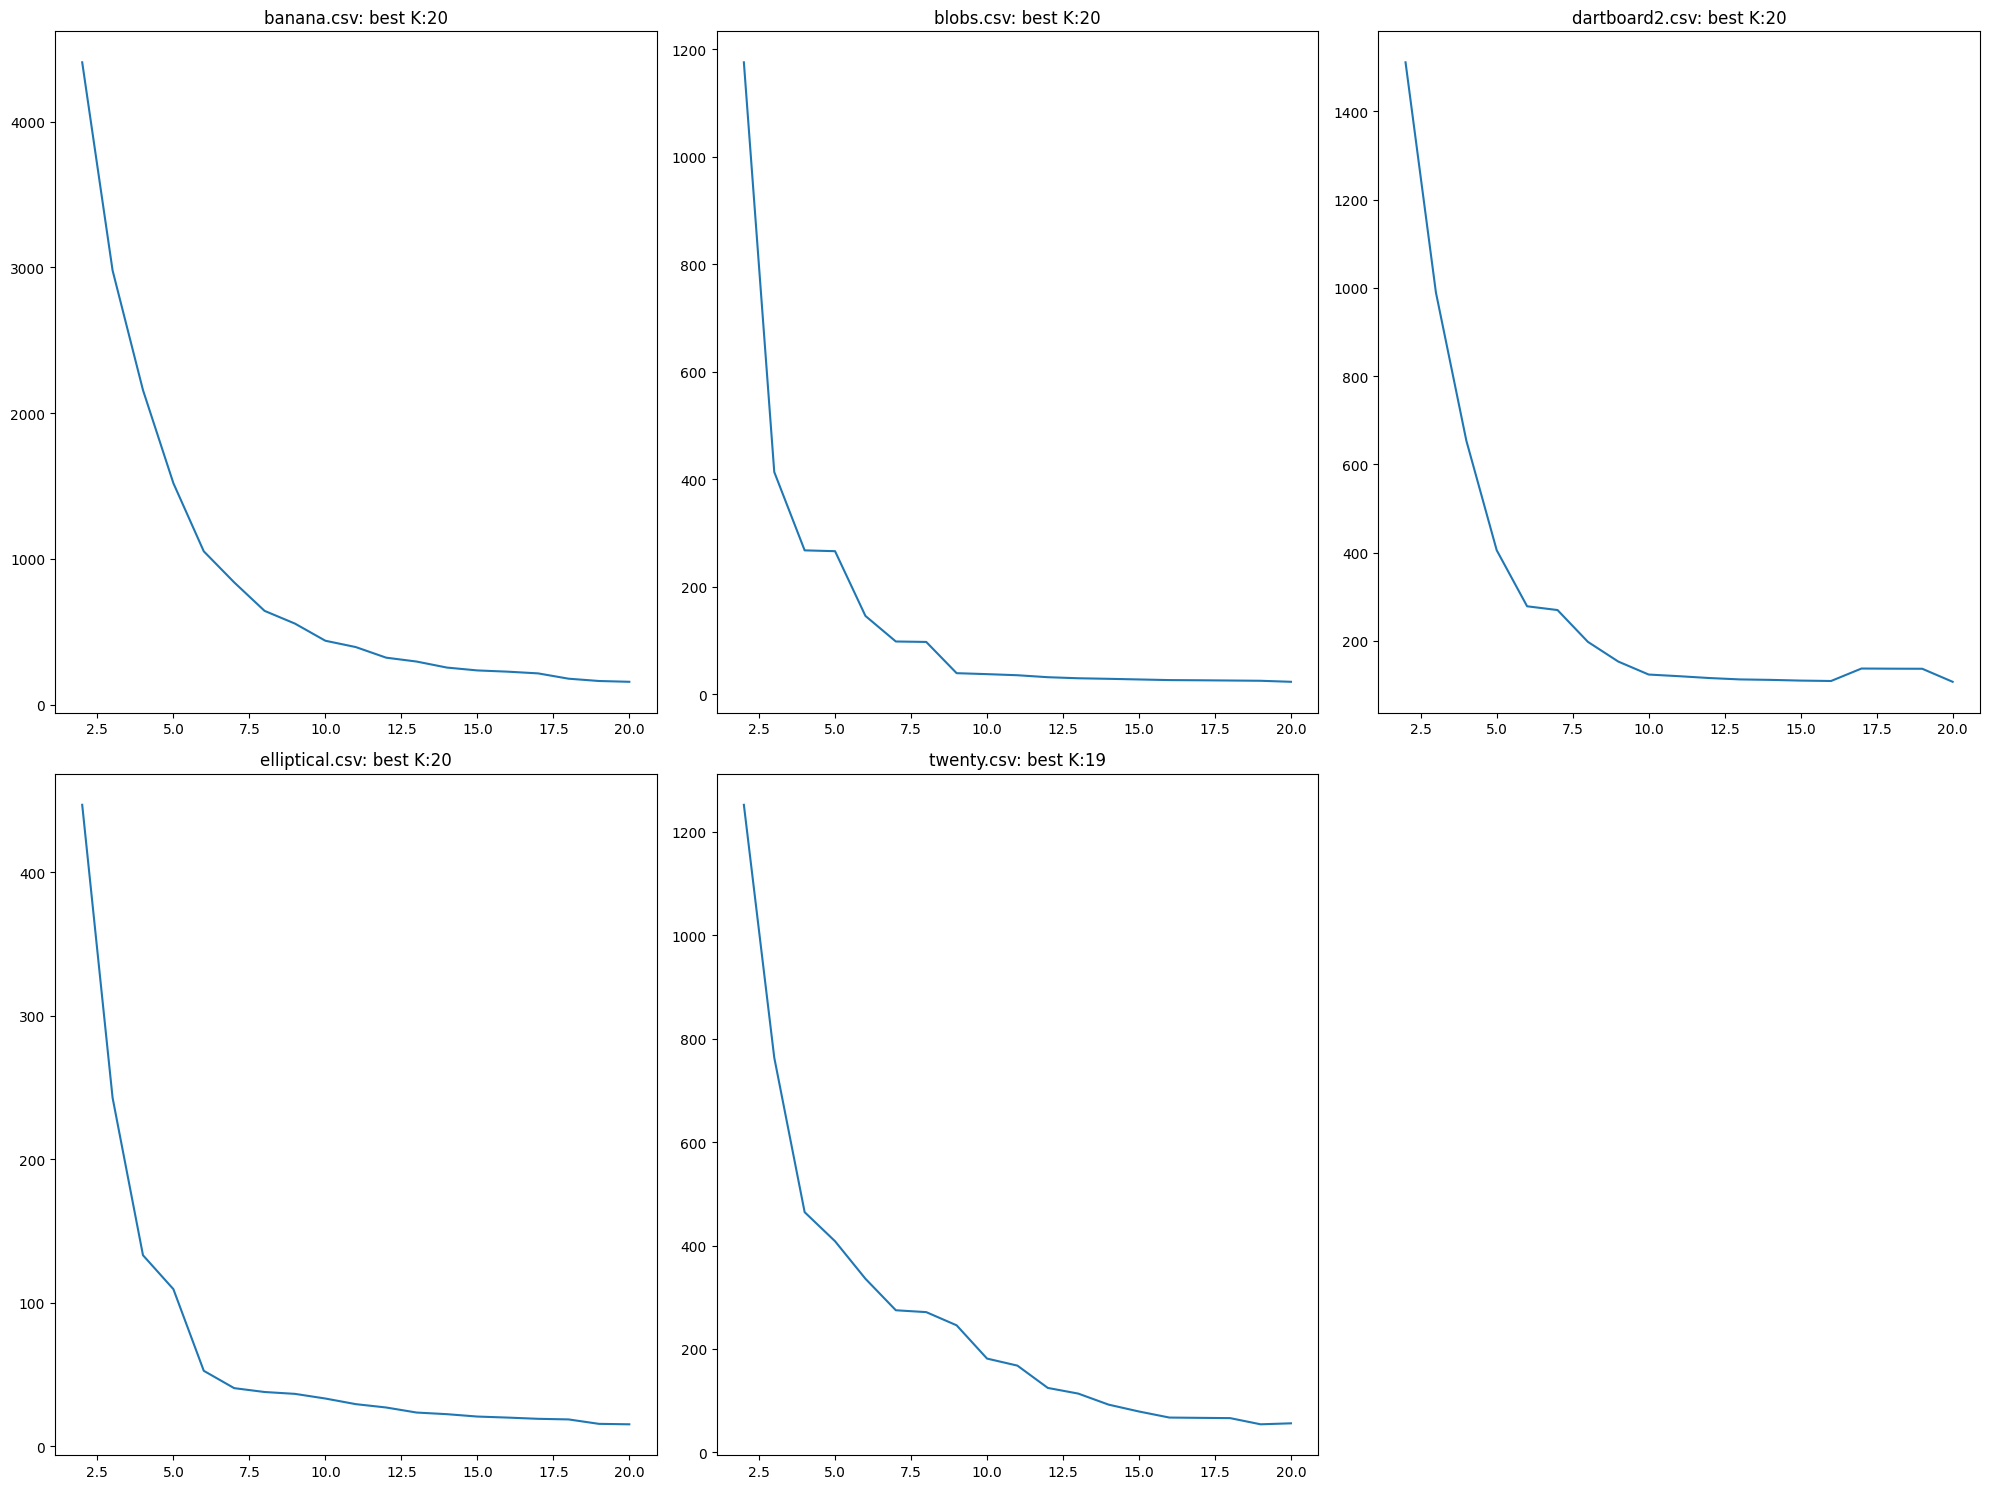

In [8]:
num_datasets = len(datasets)
num_rows = int(np.ceil(num_datasets / 3))  
wcss_best_k = []
fig, axs = plt.subplots(num_rows, 3, figsize=(20, 15))  
for i, (dataset, y_true) in enumerate(datasets):
    wcss = []
    X = dataset.values
    for k in range(2, 21):  
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    row_idx = i // 3
    col_idx = i % 3
    axs[row_idx, col_idx].plot(list(range(2, 21)), wcss)
    best_k = np.argmin(wcss)+2
    axs[row_idx, col_idx].set_title(f'{datasets_path[i]}: best K:{best_k}')
    wcss_best_k.append(best_k)

for j in range(i + 1, num_rows * 3):
    axs[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.show()

# Q6

Davies Bouldin Index(DBI):
It measures the compactness and separation between clusters. Lower values of DBI indicate better clustering solutions.
The DBI is defined for a specific cluster i as the average similarity-to-dissimilarity ratio over all other clusters j. 
S_i​ is the average distance of all points in cluster i to the centroid of cluster i.
M_ij​ is the distance between the centroids of clusters i and j.
The DBI assesses how well-separated clusters are from each other, while also considering the compactness of individual clusters.
The max identifies the cluster that has the highest similarity-to-dissimilarity ratio with the current cluster ii.

$$ \text{DBI} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{S_i + S_j}{M_{ij}} \right) $$

In [9]:
def pairwise_distances(X):
    num_points = X.shape[0]
    distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i+1, num_points):
            distance_ij = np.linalg.norm(X[i] - X[j])
            distances[i, j] = distance_ij
            distances[j, i] = distance_ij
    return distances


def calculate_scatter(cluster_points, centroid):
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    return np.mean(distances)

def davies_bouldin_score(X, labels, centroids):
    n_clusters = len(np.unique(labels))
    cluster_scatters = np.zeros(n_clusters)

    for i in range(n_clusters):
        cluster_points = X[labels == i]
        centroid = centroids[i]
        cluster_scatters[i] = calculate_scatter(cluster_points, centroid)

    db_scores = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                db_scores[i, j] = (cluster_scatters[i] + cluster_scatters[j]) / pairwise_distances(centroids)[i,j]


    db_scores[np.isinf(db_scores)] = 0
    db_scores[np.isnan(db_scores)] = 0

  
    dbi = np.mean(np.max(db_scores, axis=1))
    return dbi


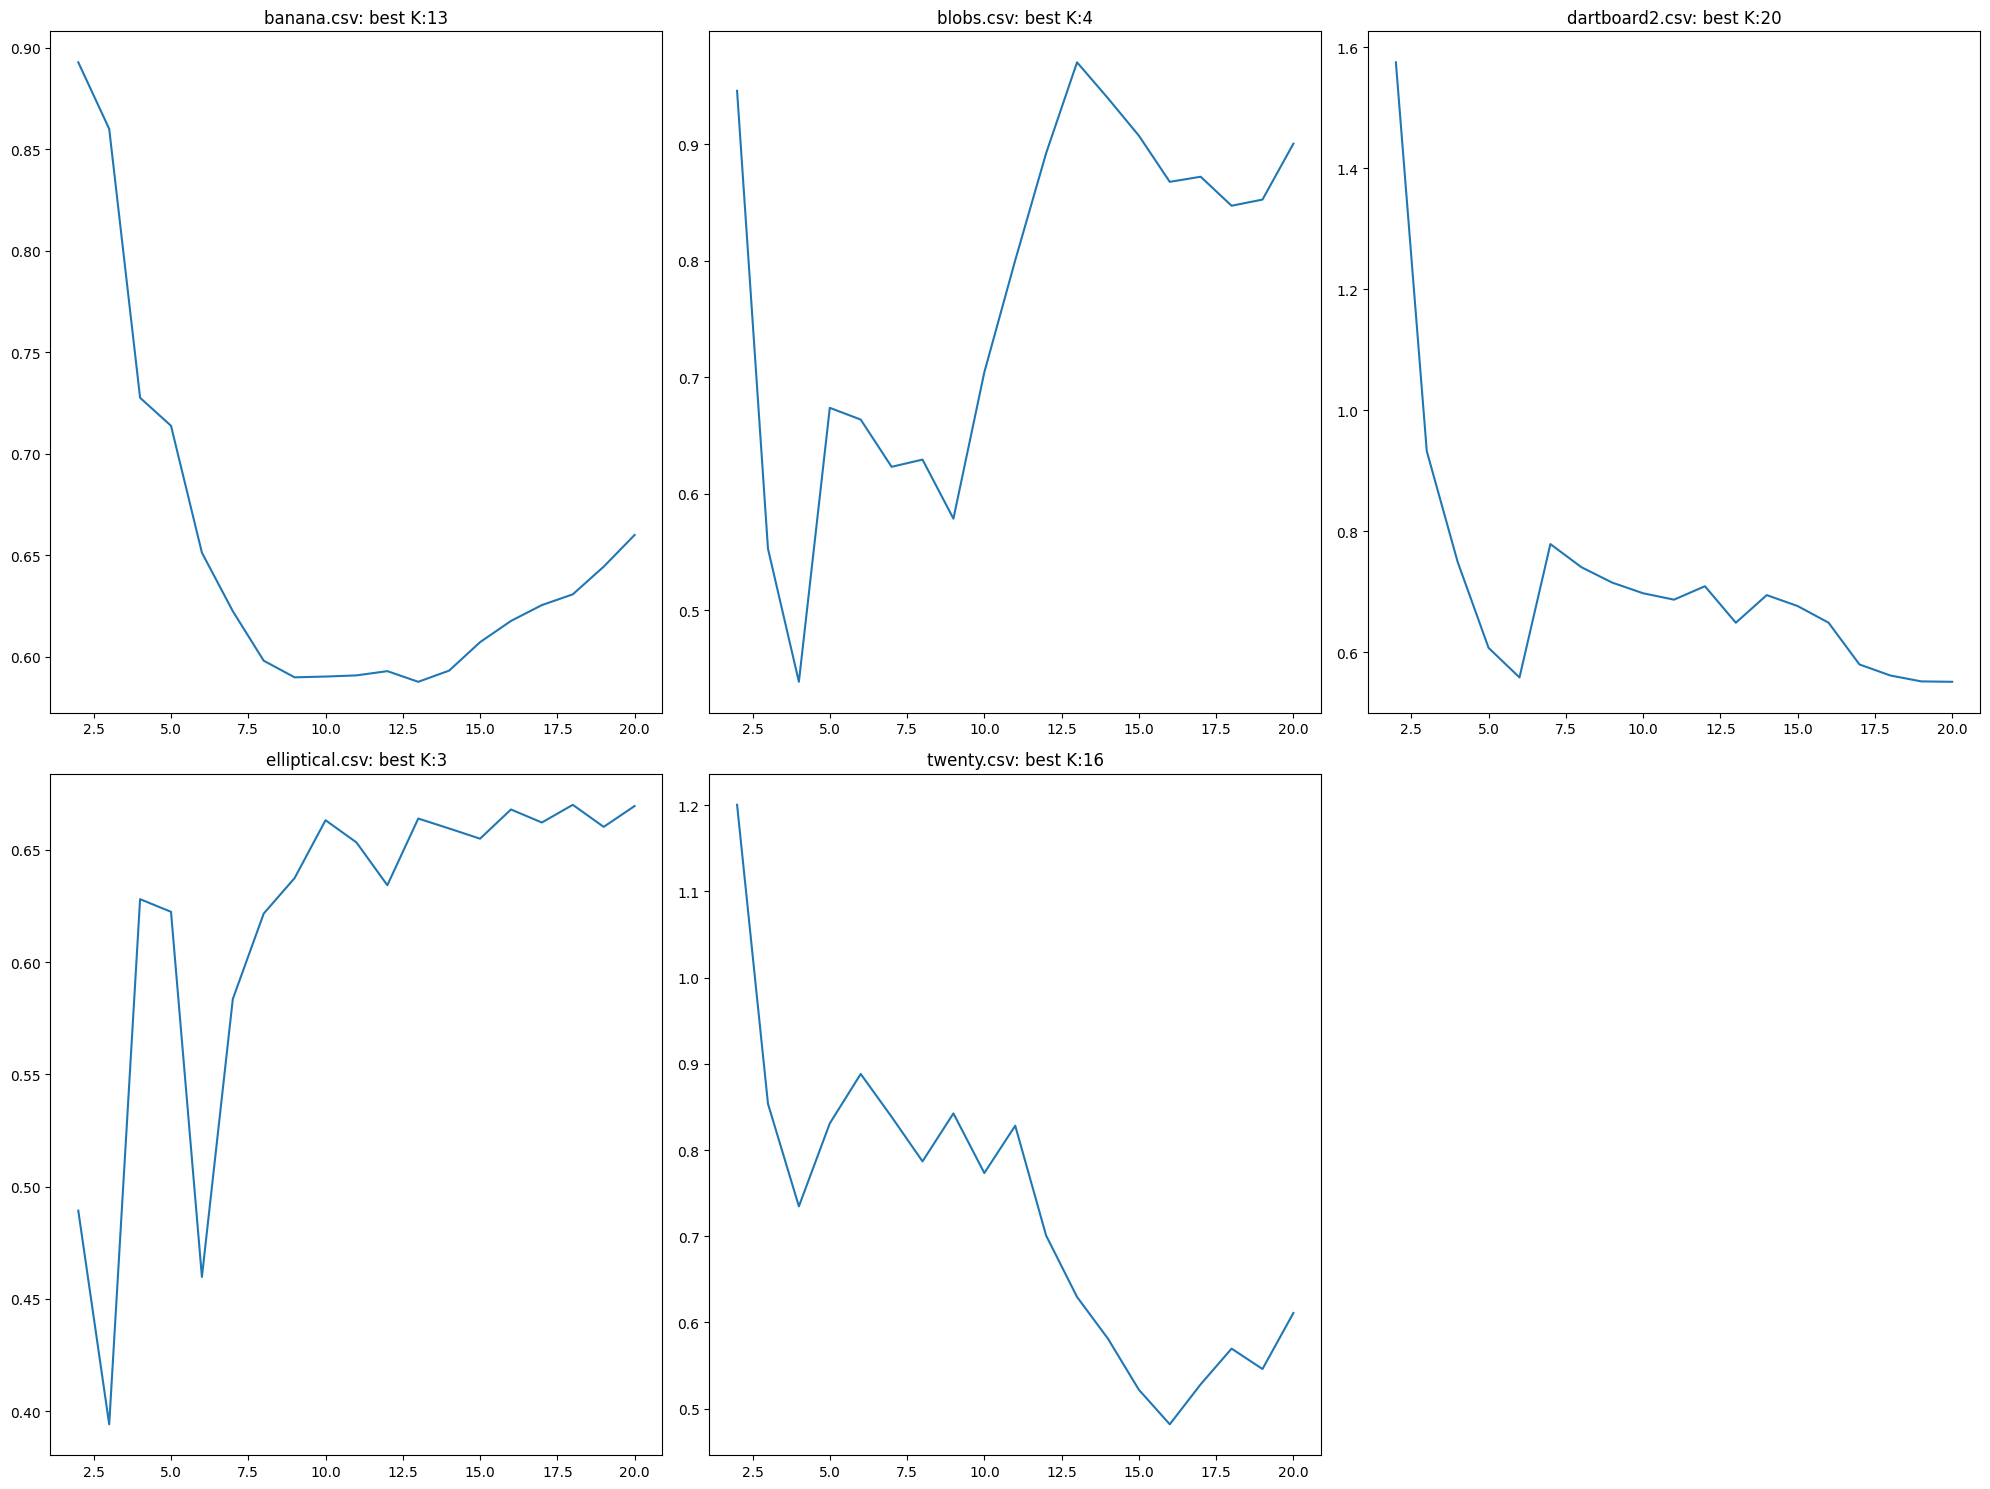

In [10]:
num_datasets = len(datasets)
num_rows = int(np.ceil(num_datasets / 3))  

fig, axs = plt.subplots(num_rows, 3, figsize=(20, 15))  
dbi_best_k = []
for i, (dataset, y_true) in enumerate(datasets):
    X = dataset.values
    dbi_scores = []

    for k in range(2, 21):
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=42)
        kmeans.fit(X)
        dbi = davies_bouldin_score(X, kmeans.labels_, kmeans.centroids)
        dbi_scores.append(dbi)

    row_idx = i // 3
    col_idx = i % 3
    axs[row_idx, col_idx].plot(list(range(2, 21)), dbi_scores)
    best_k = np.argmin(dbi_scores) + 2
    axs[row_idx, col_idx].set_title(f'{datasets_path[i]}: best K:{best_k}')
    dbi_best_k.append(best_k)
    

for j in range(i + 1, num_rows * 3):
    axs[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.show()

# Q7,9

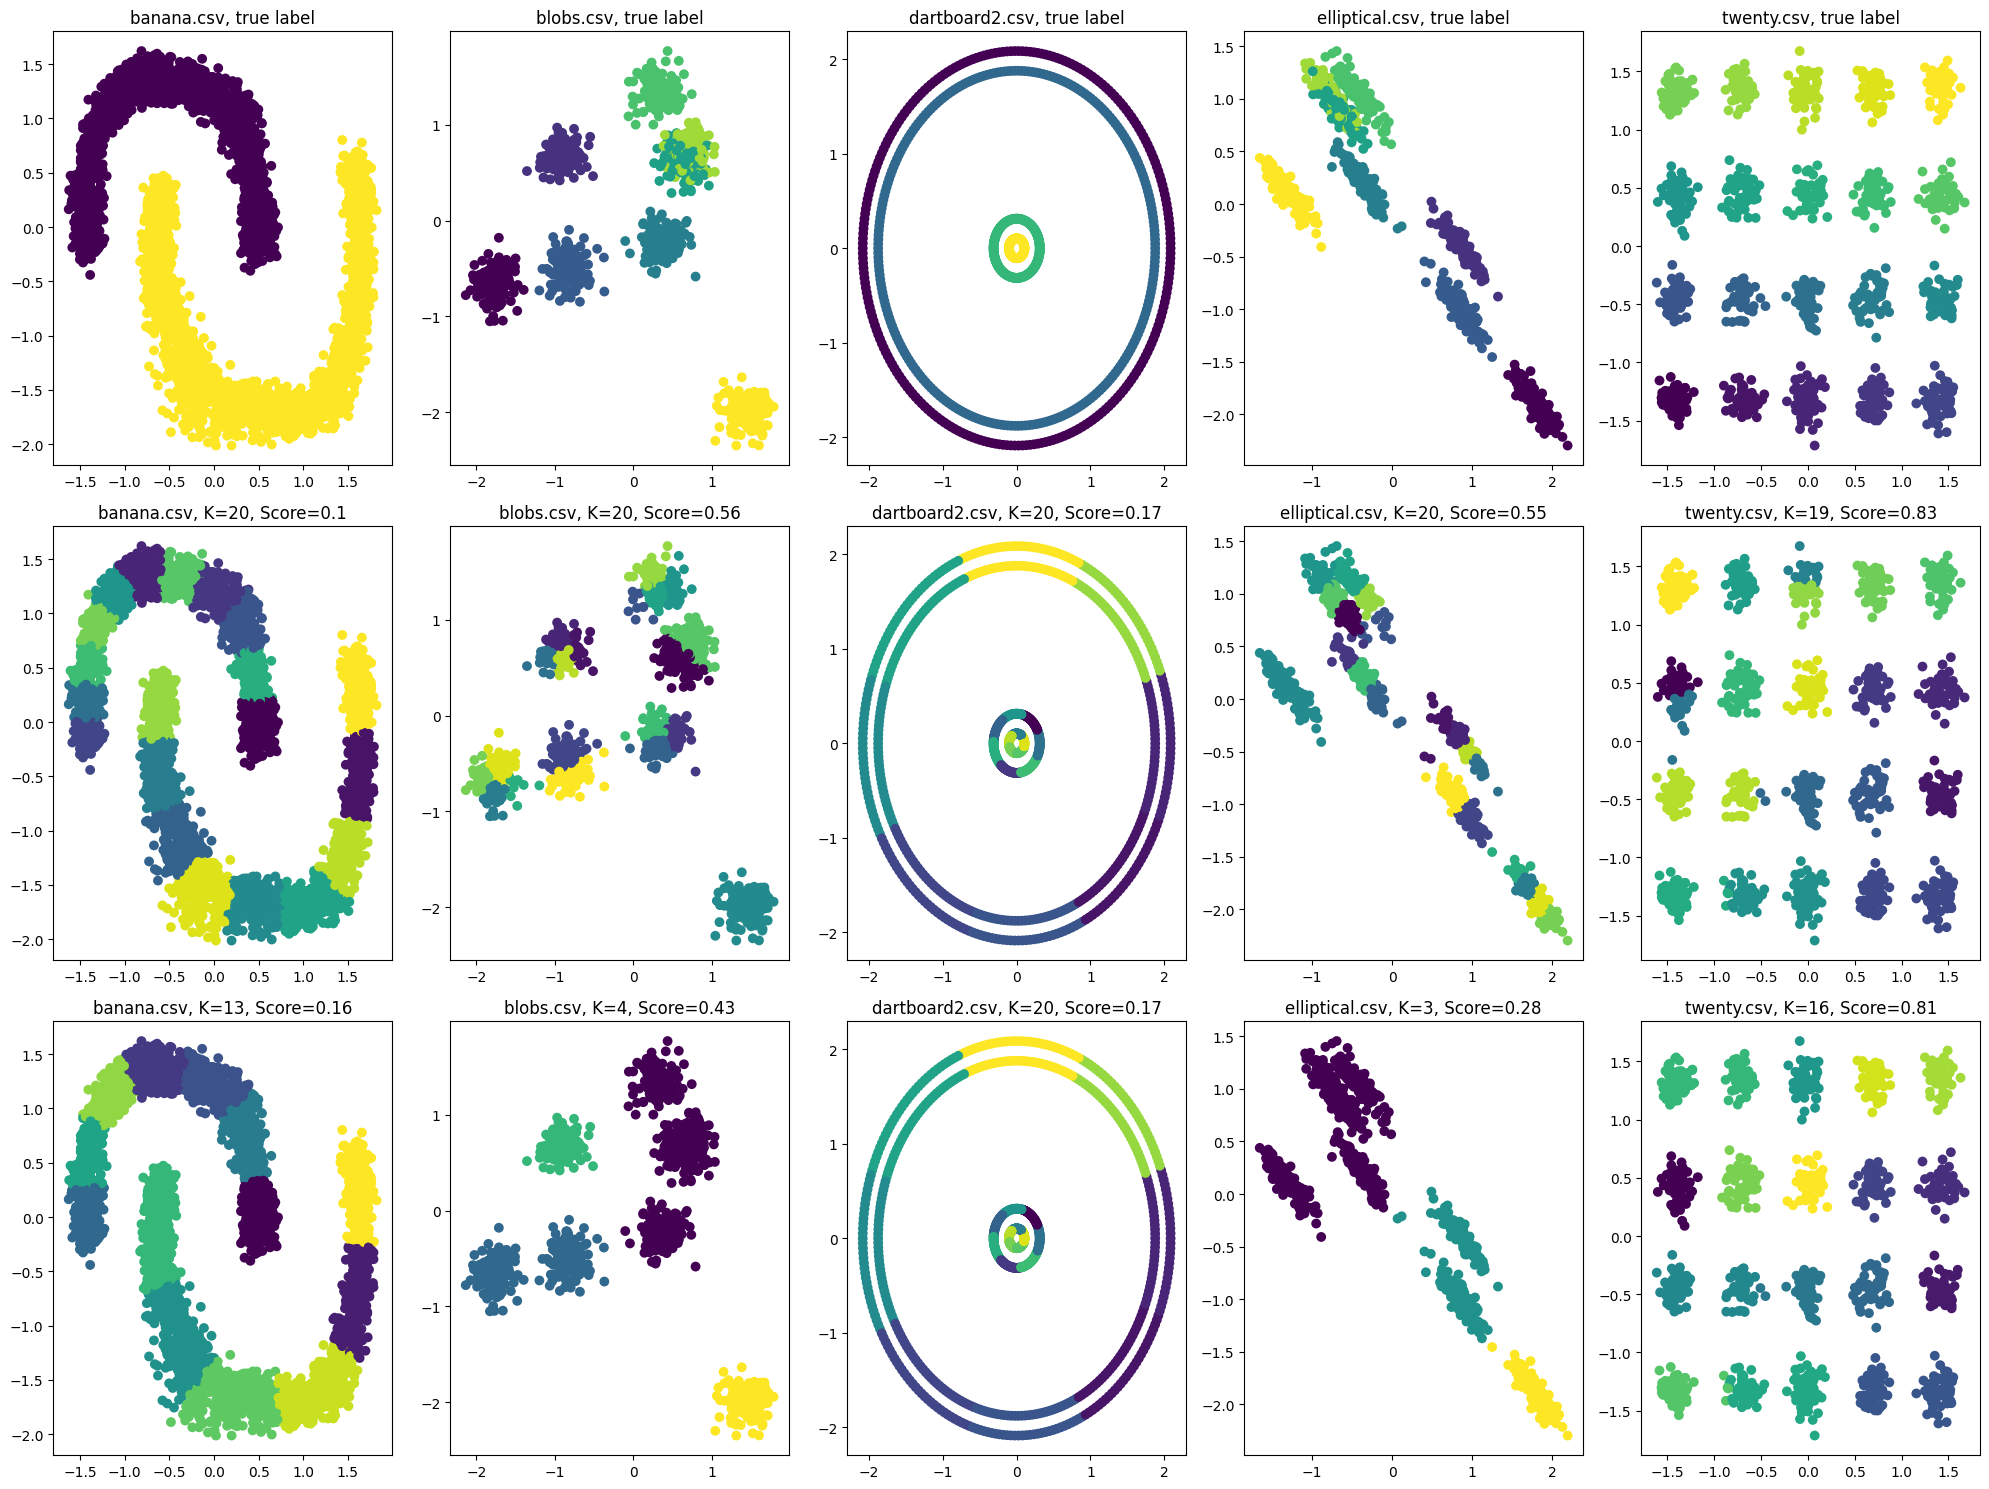

In [12]:
fig, axs = plt.subplots(3, len(datasets), figsize=(20, 15))  
for j, (dataset, labels) in enumerate(datasets):
    axs[0, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', linewidth=0)
    axs[0, j].set_title(f'{datasets_path[j]}, true label')
    
for i , best_k in enumerate([wcss_best_k, dbi_best_k]):
    for j, (dataset, y_true) in enumerate(datasets):
        kmeans = KMeans(best_k[j], random_state=42)
        y_pred = kmeans.fit_predict(dataset.values)
        axs[i+1, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=y_pred, cmap='viridis', s=50, edgecolors='k', linewidth=0)
#         plot_kmeans_clusters(dataset, kmeans.centroids,best_k[j] y_pred, ax=axs[i, j])
        ari = adjusted_rand_score(np.array(y_true), np.array(y_pred))
        axs[i+1, j].set_title(f'{datasets_path[j]}, K={best_k[j]}, Score={round(ari, 2)}')

plt.tight_layout()
plt.show()

# Q8

1. **WCSS Emphasizes Compactness:** WCSS is more sensitive to the compactness of clusters. If the datasets tend to have well-defined, tight clusters, WCSS might consistently suggest the same optimal k.

2. **DBI Considers both Compactness and Separation:** DBI, on the other hand, takes into account both the compactness of clusters and the separation between them. If the datasets have clusters that are not well-separated or have irregular shapes, DBI might provide a more nuanced evaluation.

3. **Data Characteristics:** Different datasets with distinct characteristics may lead to different optimal k values based on how well-defined and separated the clusters are.

4. **Sensitivity to Noise and Outliers:** WCSS is sensitive to noise and outliers, as it aims to minimize the sum of squared distances. DBI, by considering the ratio between clusters, might be more robust to the influence of outliers.

If there is agreement between the two methods, it strengthens the confidence in the chosen number of clusters.

# Q9

The Rand Index (RI) is a measure that quantifies the similarity between two clusterings by counting the number of pairs of data points that are either in the same cluster or in different clusters in both the true and predicted clusterings. The adjusted version, ARI, corrects for the expected similarity under random chance.

$$ ARI = \frac{2 \times (tp \times tn - fn \times fp)}{(tp + fn) \times (fn + tn) + (tp + fp) \times (fp + tn)} $$

The ARI value ranges from -1 to 1:
- ARI = 1 indicates perfect similarity between the two clusterings.
- ARI = 0 indicates that the clustering results are no better than random.
- ARI < 0 suggests that the clusterings are less similar than expected by chance.

pair confusion matrix:
   - counts the number of samples that are assigned to the same or different clusters in both the 
